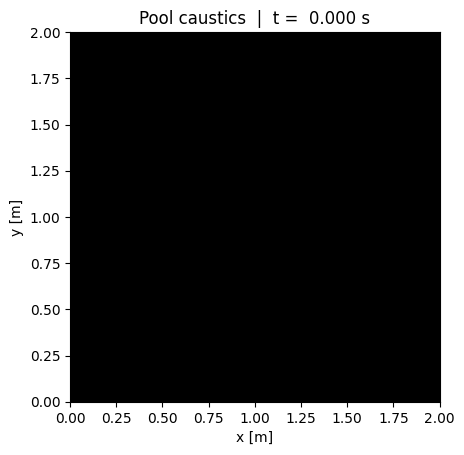

In [1]:
#!/usr/bin/env python3
"""
Pool caustics simulator (geometric optics):

- Water surface z=h(x,y,t) is synthesized in Fourier space (Tessendorf-style, band-limited ripples).
- Sunlight is a parallel beam from a chosen elevation/azimuth.
- At each (x,y) on the surface, compute normal, refract with Snell, intersect the pool floor.
- Accumulate ray power on the bottom with a weighted 2D histogram -> caustic pattern.
- Animate with matplotlib.

Dependencies:
  - numpy
  - matplotlib

Optional:
  - scipy (for nicer blur via gaussian_filter), not required.
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# ----------------------------
# Physics / math helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.
    I is a 3-vector (constant incident direction), rays pointing downward.

    Returns: (tx, ty, tz, cosi) where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    # cos(theta_i) with N pointing upward, I downward -> dot(N,I) negative, so cosi = -dot(N,I)
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    # k = 1 - eta^2 (1 - cos^2)
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation using Schlick reflectance.
    Returns T ≈ 1 - R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# Spectral ripple surface (Tessendorf-like)
# ----------------------------

class SpectralRipples:
    """
    Band-limited ripple field using a Tessendorf-style time evolution in Fourier space:

        H(k,t) = h0(k) e^{ i ω t } + h0*(−k) e^{ −i ω t }

    This guarantees a real spatial height field for all t.
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 target_rms: float = 0.004,
                 lambda0: float = 0.15, bandwidth: float = 0.07,
                 seed: int = 0):
        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.g = 9.81

        rng = np.random.default_rng(seed)

        # Wavevectors on the FFT grid
        kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=self.dx)
        ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=self.dy)
        KX, KY = np.meshgrid(kx, ky)  # (Ny,Nx)
        k = np.sqrt(KX**2 + KY**2)

        # Dispersion (finite depth): ω^2 = g k tanh(kH)
        omega = np.sqrt(self.g * k * np.tanh(k * depth))
        omega[k == 0.0] = 0.0
        self.omega = omega

        # Band-limited spectrum centered at k0 = 2π/λ0
        k0 = 2.0 * np.pi / lambda0
        sigma_k = 2.0 * np.pi / max(bandwidth, 1e-6)
        # A gentle band-pass; tweak to taste
        S = np.exp(-0.5 * ((k - k0) / sigma_k)**2)
        S[k == 0.0] = 0.0

        # Random complex Gaussian h0(k) with variance proportional to S(k)
        h0 = (rng.standard_normal((Ny, Nx)) + 1j * rng.standard_normal((Ny, Nx))) * np.sqrt(S / 2.0)

        # Build h0*(−k) lookup via index map
        iy_neg = (-np.arange(Ny)) % Ny
        ix_neg = (-np.arange(Nx)) % Nx
        h0_neg = h0[iy_neg[:, None], ix_neg[None, :]]
        h0_star_neg = np.conj(h0_neg)

        # Scale to requested RMS height at t=0
        H_hat_0 = h0 + h0_star_neg
        h_spatial_0 = np.fft.ifft2(H_hat_0).real
        rms = h_spatial_0.std()
        scale = (target_rms / rms) if rms > 0 else 1.0
        self.h0 = h0 * scale
        self.h0_star_neg = h0_star_neg * scale

        # Precompute surface coordinate grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

    def height(self, t: float) -> np.ndarray:
        exp_pos = np.exp(1j * self.omega * t)
        exp_neg = np.conj(exp_pos)
        H_hat = self.h0 * exp_pos + self.h0_star_neg * exp_neg
        return np.fft.ifft2(H_hat).real


# ----------------------------
# Caustic rendering
# ----------------------------

def caustics_frame(surface: SpectralRipples,
                   t: float,
                   bottom_res: int = 700,
                   sun_elev_deg: float = 60.0,
                   sun_az_deg: float = 20.0,
                   n_air: float = 1.0,
                   n_water: float = 1.333,
                   exposure: float = 60.0,
                   gamma: float = 0.7,
                   wrap: bool = True,
                   blur_sigma_px: float | None = None) -> np.ndarray:
    """
    Compute a tonemapped caustic image on the pool floor for time t.
    If wrap=True we wrap rays periodically into the simulated patch to avoid edge loss.
    """
    h = surface.height(t)
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    H = surface.depth

    # Surface slopes (finite difference; faster than extra FFTs and plenty accurate for ripples)
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (pointing upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Rays that go downward in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -H
    s = (-H - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights:
    #   - Fresnel transmission
    #   - cosi factor (projected flux)
    #   - divide by nz to convert from surface area to horizontal grid area (small correction; optional but sensible)
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    # Flatten and apply mask
    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate ray density / flux on the bottom via weighted histogram
    img, _, _ = np.histogram2d(
        by1, bx1,
        bins=(bottom_res, bottom_res),
        range=[[0.0, Ly], [0.0, Lx]],
        weights=w1
    )

    # Optional blur (finite sun disk / micro-scatter regularization)
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            # No SciPy: do a cheap FFT-based Gaussian blur (periodic)
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap (caustics are high-dynamic-range)
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """
    Periodic Gaussian blur via FFT. Avoids SciPy dependency.
    """
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    # In pixel units: exp(-0.5 sigma^2 k^2)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # --- Geometry / discretization ---
    Nx = Ny = 256          # surface grid (rays)
    Lx = Ly = 2.0          # simulated patch size [m]
    depth = 1.2            # pool depth [m]
    bottom_res = 700       # output pixels for bottom caustics

    # --- Ripple spectrum ---
    wave_rms = 0.004       # RMS height [m] (~4 mm)
    lambda0 = 0.14         # dominant ripple wavelength [m]
    bandwidth = 0.06       # controls bandpass width [m]
    seed = 3

    # --- Sun / optics ---
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # --- Display / tonemap ---
    exposure = 70.0
    gamma = 0.75
    blur_sigma_px = 1.0    # set None for no blur

    # --- Animation ---
    fps = 30
    dt = 1.0 / fps
    frames = 300

    surface = SpectralRipples(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        target_rms=wave_rms,
        lambda0=lambda0, bandwidth=bandwidth,
        seed=seed
    )

    fig, ax = plt.subplots()
    ax.set_title("Pool caustics (geometric optics)")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    img0 = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap="gray"
    )

    def update(k: int):
        t = k * dt
        img = caustics_frame(
            surface, t,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        ax.set_title(f"Pool caustics  |  t = {t:6.3f} s")
        return (im,)

    ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=True)
    plt.show()


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
"""
Pool caustics simulator (geometric optics).

Fixes vs. previous version:
1) Animation now displays in Jupyter/VSCode/Colab by rendering HTML (jshtml/video).
2) No more “all black” first frame: we initialize imshow with a real frame and fix vmin/vmax to [0,1].
3) Notebook defaults are reduced a bit to avoid massive embedded animations (you can raise them).

Deps: numpy, matplotlib
Optional: scipy (for gaussian_filter). If missing, a periodic FFT blur is used instead.

Run as script:
  python pool_caustics.py

Run in a notebook cell:
  just execute this file’s contents (or import and call main()) and you should see the animation inline.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    """Best-effort detection for Jupyter/Colab/VSCode notebooks."""
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I

    # cos(theta_i) with N upward, I downward -> dot(N,I) negative, so cosi = -dot(N,I)
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    # k = 1 - eta^2 (1 - cos^2)
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# Spectral ripple surface (Tessendorf-like)
# ----------------------------

class SpectralRipples:
    """
    Band-limited ripple field using Tessendorf-style time evolution in Fourier space:

        H(k,t) = h0(k) e^{ i ω t } + h0*(−k) e^{ −i ω t }

    Guarantees real-valued heights for all t.
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 target_rms: float = 0.004,
                 lambda0: float = 0.15, bandwidth: float = 0.07,
                 seed: int = 0):
        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.g = 9.81

        rng = np.random.default_rng(seed)

        # Wavevectors on the FFT grid
        kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=self.dx)
        ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=self.dy)
        KX, KY = np.meshgrid(kx, ky)  # (Ny,Nx)
        k = np.sqrt(KX**2 + KY**2)

        # Dispersion (finite depth): ω^2 = g k tanh(kH)
        omega = np.sqrt(self.g * k * np.tanh(k * depth))
        omega[k == 0.0] = 0.0
        self.omega = omega

        # Band-limited spectrum centered at k0 = 2π/λ0
        k0 = 2.0 * np.pi / lambda0
        sigma_k = 2.0 * np.pi / max(bandwidth, 1e-6)
        S = np.exp(-0.5 * ((k - k0) / sigma_k) ** 2)
        S[k == 0.0] = 0.0

        # Random complex Gaussian h0(k) with variance proportional to S(k)
        h0 = (rng.standard_normal((Ny, Nx)) + 1j * rng.standard_normal((Ny, Nx))) * np.sqrt(S / 2.0)

        # Build h0*(−k) lookup via index map
        iy_neg = (-np.arange(Ny)) % Ny
        ix_neg = (-np.arange(Nx)) % Nx
        h0_neg = h0[iy_neg[:, None], ix_neg[None, :]]
        h0_star_neg = np.conj(h0_neg)

        # Scale to requested RMS height at t=0
        H_hat_0 = h0 + h0_star_neg
        h_spatial_0 = np.fft.ifft2(H_hat_0).real
        rms = h_spatial_0.std()
        scale = (target_rms / rms) if rms > 0 else 1.0

        self.h0 = h0 * scale
        self.h0_star_neg = h0_star_neg * scale

        # Spatial grid on the surface
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

    def height(self, t: float) -> np.ndarray:
        exp_pos = np.exp(1j * self.omega * t)
        exp_neg = np.conj(exp_pos)
        H_hat = self.h0 * exp_pos + self.h0_star_neg * exp_neg
        return np.fft.ifft2(H_hat).real


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def caustics_frame(surface: SpectralRipples,
                   t: float,
                   bottom_res: int = 420,
                   sun_elev_deg: float = 60.0,
                   sun_az_deg: float = 20.0,
                   n_air: float = 1.0,
                   n_water: float = 1.333,
                   exposure: float = 60.0,
                   gamma: float = 0.7,
                   wrap: bool = True,
                   blur_sigma_px: float | None = 1.0
                   ) -> np.ndarray:
    """
    Compute a tonemapped caustic image on the pool floor for time t.
    Returns float image in [0,1].
    """
    h = surface.height(t)
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    H = surface.depth

    # Surface slopes (finite difference)
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Rays must go downward in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -H
    s = (-H - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    # Flatten and apply mask
    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate irradiance via weighted histogram
    img, _, _ = np.histogram2d(
        by1, bx1,
        bins=(bottom_res, bottom_res),
        range=[[0.0, Ly], [0.0, Lx]],
        weights=w1
    )

    # Optional blur (finite sun disk / regularization)
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def display_animation(fig, ani) -> None:
    """
    Show animation:
    - In notebooks: embed as HTML (video if possible, else jshtml).
    - Else: normal plt.show().
    """
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(float(mpl.rcParams.get("animation.embed_limit", 20)), 100.0)

        from IPython.display import HTML, display  # type: ignore

        # Prevent the notebook from also showing a static first frame
        plt.close(fig)

        # Prefer HTML5 video (smaller) if ffmpeg is available; otherwise fall back to jshtml.
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()

        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # --- Geometry / discretization ---
    Nx = Ny = 256          # surface grid (rays)
    Lx = Ly = 2.0          # simulated patch size [m]
    depth = 1.2            # pool depth [m]

    # Defaults: smaller for notebooks (embedded animation size), larger for normal scripts.
    if running_in_notebook():
        bottom_res = 420
        frames = 180
    else:
        bottom_res = 700
        frames = 300

    # --- Ripple spectrum ---
    wave_rms = 0.004       # RMS height [m] (~4 mm)
    lambda0 = 0.14         # dominant ripple wavelength [m]
    bandwidth = 0.06       # bandpass width [m]
    seed = 3

    # --- Sun / optics ---
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # --- Tonemap / regularization ---
    exposure = 70.0
    gamma = 0.75
    blur_sigma_px = 1.0

    # --- Animation ---
    fps = 30
    dt = 1.0 / fps

    surface = SpectralRipples(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        target_rms=wave_rms,
        lambda0=lambda0, bandwidth=bandwidth,
        seed=seed
    )

    fig, ax = plt.subplots()
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    # IMPORTANT FIX: initialize with a *real* frame (not zeros),
    # and pin the colormap range to [0,1] to avoid “black forever”.
    img0 = caustics_frame(
        surface, 0.0,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap="gray",
        vmin=0.0, vmax=1.0
    )
    ax.set_title("Pool caustics | t = 0.000 s")

    def update(k: int):
        t = k * dt
        img = caustics_frame(
            surface, t,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        ax.set_title(f"Pool caustics | t = {t:7.3f} s")
        return (im,)

    # IMPORTANT FIX: blit=False is much more robust across notebook backends.
    ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)

    display_animation(fig, ani)


if __name__ == "__main__":
    main()


In [5]:
#!/usr/bin/env python3
"""
Pool caustics simulator (geometric optics) — smoother, longer waves.

Key changes vs earlier version:
  1) Wave spectrum uses a narrow Gaussian in k-space: k_sigma_frac * k0.
     This avoids injecting lots of short-wavelength “noise”.
  2) Bottom accumulation uses bilinear splatting (4-pixel deposit) instead of histogram2d,
     greatly reducing Monte-Carlo/shot noise.
  3) Animation displays in notebooks via HTML (jshtml/video), otherwise via plt.show().

Deps: numpy, matplotlib
Optional: scipy (for gaussian_filter). If missing, periodic FFT blur is used.

Tuning knobs you care about:
  - lambda0        : dominant wavelength (m)  e.g. 0.4 .. 1.2
  - k_sigma_frac   : spectral width (fraction of k0). Smaller = smoother/less variety.
  - wave_rms       : RMS surface height (m). For longer waves, you need larger amplitude
                     to keep slopes (and caustic contrast) visible.
  - bottom_res     : image resolution. If too high relative to ray count, you get speckle.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# Spectral ripple surface (band-limited, long-wave friendly)
# ----------------------------

class SpectralRipples:
    """
    Band-limited ripple field using Tessendorf-style time evolution in Fourier space:

        H(k,t) = h0(k) e^{ i ω t } + h0*(−k) e^{ −i ω t }

    Real for all t. Spectrum here is a narrow Gaussian around k0 = 2π/lambda0.

    Parameters for "pool-like" longer waves:
      lambda0 ~ 0.4..1.2 m
      k_sigma_frac ~ 0.08..0.25   (smaller = smoother, less "busy")
      target_rms ~ 0.008..0.02 m  (8 mm .. 2 cm)
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 target_rms: float = 0.012,
                 lambda0: float = 0.60,
                 k_sigma_frac: float = 0.12,
                 direction_deg: float | None = None,
                 dir_spread_deg: float = 80.0,
                 seed: int = 0):
        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.g = 9.81

        rng = np.random.default_rng(seed)

        # Wavevectors on the FFT grid
        kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=self.dx)
        ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=self.dy)
        KX, KY = np.meshgrid(kx, ky)  # (Ny,Nx)
        k = np.sqrt(KX**2 + KY**2)

        # Dispersion (finite depth): ω^2 = g k tanh(kH)
        omega = np.sqrt(self.g * k * np.tanh(k * depth))
        omega[k == 0.0] = 0.0
        self.omega = omega

        # Dominant wavenumber and spectral width in k-space
        k0 = 2.0 * np.pi / max(lambda0, 1e-6)
        sigma_k = max(k_sigma_frac, 1e-6) * k0

        # Narrow band around k0 (THIS is what removes tiny ripples)
        S = np.exp(-0.5 * ((k - k0) / sigma_k) ** 2)

        # Extra high-k suppression (just in case someone sets sigma too large)
        k_cut = 3.0 * k0
        S *= np.exp(-(k / max(k_cut, 1e-9)) ** 4)

        # Optional directionality (wind / push): bias wavevectors by angle
        if direction_deg is not None:
            theta = np.arctan2(KY, KX)
            theta0 = np.deg2rad(direction_deg)
            # wrapped angular difference in [-pi, pi]
            dtheta = np.angle(np.exp(1j * (theta - theta0)))
            sigma_th = np.deg2rad(max(dir_spread_deg, 1e-3))
            D = np.exp(-0.5 * (dtheta / sigma_th) ** 2)
            S *= D

        S[k == 0.0] = 0.0

        # Random complex Gaussian h0(k) with variance proportional to S(k)
        h0 = (rng.standard_normal((Ny, Nx)) + 1j * rng.standard_normal((Ny, Nx))) * np.sqrt(S / 2.0)

        # Build h0*(−k) lookup via index map
        iy_neg = (-np.arange(Ny)) % Ny
        ix_neg = (-np.arange(Nx)) % Nx
        h0_neg = h0[iy_neg[:, None], ix_neg[None, :]]
        h0_star_neg = np.conj(h0_neg)

        # Scale to requested RMS height at t=0
        H_hat_0 = h0 + h0_star_neg
        h_spatial_0 = np.fft.ifft2(H_hat_0).real
        rms = h_spatial_0.std()
        scale = (target_rms / rms) if rms > 0 else 1.0

        self.h0 = h0 * scale
        self.h0_star_neg = h0_star_neg * scale

        # Spatial grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

    def height(self, t: float) -> np.ndarray:
        exp_pos = np.exp(1j * self.omega * t)
        exp_neg = np.conj(exp_pos)
        H_hat = self.h0 * exp_pos + self.h0_star_neg * exp_neg
        return np.fft.ifft2(H_hat).real


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def splat_bilinear(img: np.ndarray,
                   x: np.ndarray, y: np.ndarray, w: np.ndarray,
                   Lx: float, Ly: float,
                   wrap: bool) -> None:
    """
    Deposit weighted samples (x,y,w) into img using bilinear splatting.
    img shape: (H,W) corresponds to (y,x).

    wrap=True implements periodic boundary conditions.
    """
    H, W = img.shape

    # Map physical coords to pixel coords in [0,W) and [0,H)
    u = (x / Lx) * W
    v = (y / Ly) * H

    i0 = np.floor(u).astype(np.int64)
    j0 = np.floor(v).astype(np.int64)
    fu = u - i0
    fv = v - j0

    i1 = i0 + 1
    j1 = j0 + 1

    if wrap:
        i0 %= W; i1 %= W
        j0 %= H; j1 %= H
        ww = w
        fuu = fu
        fvv = fv
    else:
        m = (i0 >= 0) & (i1 < W) & (j0 >= 0) & (j1 < H)
        if not np.any(m):
            return
        i0 = i0[m]; i1 = i1[m]
        j0 = j0[m]; j1 = j1[m]
        fuu = fu[m]; fvv = fv[m]
        ww = w[m]

    w00 = ww * (1.0 - fuu) * (1.0 - fvv)
    w10 = ww * (fuu) * (1.0 - fvv)
    w01 = ww * (1.0 - fuu) * (fvv)
    w11 = ww * (fuu) * (fvv)

    np.add.at(img, (j0, i0), w00)
    np.add.at(img, (j0, i1), w10)
    np.add.at(img, (j1, i0), w01)
    np.add.at(img, (j1, i1), w11)


def caustics_frame(surface: SpectralRipples,
                   t: float,
                   bottom_res: int = 520,
                   sun_elev_deg: float = 62.0,
                   sun_az_deg: float = 25.0,
                   n_air: float = 1.0,
                   n_water: float = 1.333,
                   exposure: float = 70.0,
                   gamma: float = 0.8,
                   wrap: bool = True,
                   blur_sigma_px: float | None = 1.5
                   ) -> np.ndarray:
    """
    Compute a tonemapped caustic image on the pool floor for time t.
    Returns float image in [0,1].
    """
    h = surface.height(t)
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    Hdepth = surface.depth

    # Surface slopes
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Downward-going rays in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -Hdepth
    s = (-Hdepth - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate on bottom with bilinear splatting (low speckle)
    img = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    splat_bilinear(img, bx1, by1, w1, Lx=Lx, Ly=Ly, wrap=wrap)

    # Optional blur: finite sun disk / regularization
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def display_animation(fig, ani) -> None:
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(float(mpl.rcParams.get("animation.embed_limit", 20)), 120.0)
        from IPython.display import HTML, display  # type: ignore
        plt.close(fig)
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()
        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # Geometry / discretization
    Nx = Ny = 256
    Lx = Ly = 2.0
    depth = 1.2

    # Output resolution (too high vs rays -> speckle)
    if running_in_notebook():
        bottom_res = 520
        frames = 180
    else:
        bottom_res = 700
        frames = 300

    # Sun / optics
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # --- Surface: LONGER WAVES (main change) ---
    # Dominant wavelength (m) — push this up for larger undulations
    lambda0 = 0.60

    # Spectral width in k-space as a fraction of k0
    # Smaller -> fewer wave components -> smoother surface
    k_sigma_frac = 0.12

    # RMS height (m). For longer waves you need more amplitude to keep slopes visible.
    wave_rms = 0.012   # 1.2 cm RMS

    # Optional directionality (try enabling for more “pool push” coherence):
    direction_deg = None      # e.g. 0.0 to bias along +x, or None for isotropic
    dir_spread_deg = 90.0     # wider = more isotropic

    # Caustics tonemap/regularization
    exposure = 70.0
    gamma = 0.80
    blur_sigma_px = 1.5

    # Animation
    fps = 30
    dt = 1.0 / fps

    surface = SpectralRipples(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        target_rms=wave_rms,
        lambda0=lambda0,
        k_sigma_frac=k_sigma_frac,
        direction_deg=direction_deg,
        dir_spread_deg=dir_spread_deg,
        seed=3
    )

    fig, ax = plt.subplots()
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    # Initialize with real first frame; lock colormap to [0,1]
    img0 = caustics_frame(
        surface, 0.0,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap="gray",
        vmin=0.0, vmax=1.0
    )
    ax.set_title("Pool caustics | t = 0.000 s")

    def update(k: int):
        t = k * dt
        img = caustics_frame(
            surface, t,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        ax.set_title(f"Pool caustics | t = {t:7.3f} s  |  λ0={lambda0:.2f} m, rms={wave_rms*100:.1f} cm")
        return (im,)

    #ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)
    #display_animation(fig, ani)

    ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)

    # ---- EXPORT TO MP4 ----
    from matplotlib.animation import FFMpegWriter

    writer = FFMpegWriter(fps=fps, bitrate=4000)
    ani.save("pool_caustics.mp4", writer=writer, dpi=200)

    # If you still want on-screen preview:
    display_animation(fig, ani)

if __name__ == "__main__":
    main()


In [7]:
#!/usr/bin/env python3
"""
Pool caustics simulator (geometric optics) — pool-like wavelengths and colors.

Changes vs previous version:
  - Dominant wavelength lambda0 ~ 0.25 m (20–30 cm regime).
  - RMS amplitude ~ 8 mm, tuned for that wavelength.
  - Custom "water" colormap: deep blue → turquoise → pale cyan → white highlights.
  - Rest is as before: band-limited spectral surface + bilinear splatting + tonemapping.

Deps: numpy, matplotlib
Optional: scipy (for gaussian_filter). If missing, periodic FFT blur is used.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# Spectral ripple surface (band-limited, pool-like)
# ----------------------------

class SpectralRipples:
    """
    Band-limited ripple field using Tessendorf-style time evolution in Fourier space:

        H(k,t) = h0(k) e^{ i ω t } + h0*(−k) e^{ −i ω t }

    Real for all t. Spectrum is a narrow Gaussian around k0 = 2π/lambda0.

    For "pool-like" gravity–capillary waves:
      lambda0 ~ 0.2..0.3 m
      k_sigma_frac ~ 0.10..0.20
      target_rms ~ 0.006..0.012 m
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 target_rms: float = 0.008,
                 lambda0: float = 0.25,
                 k_sigma_frac: float = 0.16,
                 direction_deg: float | None = None,
                 dir_spread_deg: float = 90.0,
                 seed: int = 0):
        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.g = 9.81

        rng = np.random.default_rng(seed)

        # Wavevectors on the FFT grid
        kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=self.dx)
        ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=self.dy)
        KX, KY = np.meshgrid(kx, ky)  # (Ny,Nx)
        k = np.sqrt(KX**2 + KY**2)

        # Dispersion (finite depth): ω^2 = g k tanh(kH)
        omega = np.sqrt(self.g * k * np.tanh(k * depth))
        omega[k == 0.0] = 0.0
        self.omega = omega

        # Dominant wavenumber and spectral width in k-space
        k0 = 2.0 * np.pi / max(lambda0, 1e-6)
        sigma_k = max(k_sigma_frac, 1e-6) * k0

        # Narrow band around k0
        S = np.exp(-0.5 * ((k - k0) / sigma_k) ** 2)

        # High-k suppression
        k_cut = 3.0 * k0
        S *= np.exp(-(k / max(k_cut, 1e-9)) ** 4)

        # Optional directionality (wind / push)
        if direction_deg is not None:
            theta = np.arctan2(KY, KX)
            theta0 = np.deg2rad(direction_deg)
            dtheta = np.angle(np.exp(1j * (theta - theta0)))  # wrapped diff
            sigma_th = np.deg2rad(max(dir_spread_deg, 1e-3))
            D = np.exp(-0.5 * (dtheta / sigma_th) ** 2)
            S *= D

        S[k == 0.0] = 0.0

        # Random complex Gaussian h0(k) with variance proportional to S(k)
        h0 = (rng.standard_normal((Ny, Nx)) + 1j * rng.standard_normal((Ny, Nx))) * np.sqrt(S / 2.0)

        # Build h0*(−k) lookup via index map
        iy_neg = (-np.arange(Ny)) % Ny
        ix_neg = (-np.arange(Nx)) % Nx
        h0_neg = h0[iy_neg[:, None], ix_neg[None, :]]
        h0_star_neg = np.conj(h0_neg)

        # Scale to requested RMS height at t=0
        H_hat_0 = h0 + h0_star_neg
        h_spatial_0 = np.fft.ifft2(H_hat_0).real
        rms = h_spatial_0.std()
        scale = (target_rms / rms) if rms > 0 else 1.0

        self.h0 = h0 * scale
        self.h0_star_neg = h0_star_neg * scale

        # Spatial grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

    def height(self, t: float) -> np.ndarray:
        exp_pos = np.exp(1j * self.omega * t)
        exp_neg = np.conj(exp_pos)
        H_hat = self.h0 * exp_pos + self.h0_star_neg * exp_neg
        return np.fft.ifft2(H_hat).real


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def splat_bilinear(img: np.ndarray,
                   x: np.ndarray, y: np.ndarray, w: np.ndarray,
                   Lx: float, Ly: float,
                   wrap: bool) -> None:
    """
    Deposit weighted samples (x,y,w) into img using bilinear splatting.
    img shape: (H,W) corresponds to (y,x).

    wrap=True implements periodic boundary conditions.
    """
    H, W = img.shape

    # Map physical coords to pixel coords in [0,W) and [0,H)
    u = (x / Lx) * W
    v = (y / Ly) * H

    i0 = np.floor(u).astype(np.int64)
    j0 = np.floor(v).astype(np.int64)
    fu = u - i0
    fv = v - j0

    i1 = i0 + 1
    j1 = j0 + 1

    if wrap:
        i0 %= W; i1 %= W
        j0 %= H; j1 %= H
        ww = w
        fuu = fu
        fvv = fv
    else:
        m = (i0 >= 0) & (i1 < W) & (j0 >= 0) & (j1 < H)
        if not np.any(m):
            return
        i0 = i0[m]; i1 = i1[m]
        j0 = j0[m]; j1 = j1[m]
        fuu = fu[m]; fvv = fv[m]
        ww = w[m]

    w00 = ww * (1.0 - fuu) * (1.0 - fvv)
    w10 = ww * (fuu) * (1.0 - fvv)
    w01 = ww * (1.0 - fuu) * (fvv)
    w11 = ww * (fuu) * (fvv)

    np.add.at(img, (j0, i0), w00)
    np.add.at(img, (j0, i1), w10)
    np.add.at(img, (j1, i0), w01)
    np.add.at(img, (j1, i1), w11)


def caustics_frame(surface: SpectralRipples,
                   t: float,
                   bottom_res: int = 520,
                   sun_elev_deg: float = 62.0,
                   sun_az_deg: float = 25.0,
                   n_air: float = 1.0,
                   n_water: float = 1.333,
                   exposure: float = 70.0,
                   gamma: float = 0.80,
                   wrap: bool = True,
                   blur_sigma_px: float | None = 1.5
                   ) -> np.ndarray:
    """
    Compute a tonemapped caustic image on the pool floor for time t.
    Returns float image in [0,1].
    """
    h = surface.height(t)
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    Hdepth = surface.depth

    # Surface slopes
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Downward-going rays in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -Hdepth
    s = (-Hdepth - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate on bottom with bilinear splatting
    img = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    splat_bilinear(img, bx1, by1, w1, Lx=Lx, Ly=Ly, wrap=wrap)

    # Optional blur: finite sun disk / regularization
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def make_water_cmap() -> LinearSegmentedColormap:
    """
    Create a simple water-like colormap:
      dark blue -> deep aqua -> turquoise -> pale cyan -> white.
    """
    colors = [
        (0.0,  (0.01, 0.05, 0.12)),   # very dark blue
        (0.25, (0.02, 0.20, 0.40)),   # deep blue
        (0.50, (0.00, 0.45, 0.70)),   # turquoise
        (0.75, (0.60, 0.90, 0.95)),   # pale cyan
        (1.0,  (1.00, 1.00, 1.00)),   # white highlights
    ]
    return LinearSegmentedColormap.from_list("pool_water", colors)


def display_animation(fig, ani) -> None:
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(
            float(mpl.rcParams.get("animation.embed_limit", 20)), 120.0
        )
        from IPython.display import HTML, display  # type: ignore
        plt.close(fig)
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()
        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # Geometry / discretization
    Nx = Ny = 256
    Lx = Ly = 2.0
    depth = 1.2

    # Output resolution
    if running_in_notebook():
        bottom_res = 520
        frames = 180
    else:
        bottom_res = 700
        frames = 300

    # Sun / optics
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # --- Surface: pool-like 20–30 cm waves ---
    lambda0 = 0.45        # dominant wavelength [m]
    k_sigma_frac = 0.16   # spectral width in k-space
    wave_rms = 0.008      # RMS height [m] ~ 8 mm
    direction_deg = None  # or e.g. 0.0 to bias along +x
    dir_spread_deg = 90.0

    # Caustics tonemap / regularization
    exposure = 70.0
    gamma = 0.80
    blur_sigma_px = 1.5

    # Animation
    fps = 30
    dt = 1.0 / fps

    surface = SpectralRipples(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        target_rms=wave_rms,
        lambda0=lambda0,
        k_sigma_frac=k_sigma_frac,
        direction_deg=direction_deg,
        dir_spread_deg=dir_spread_deg,
        seed=3
    )

    fig, ax = plt.subplots()
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    # First frame (scalar caustic intensity)
    img0 = caustics_frame(
        surface, 0.0,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    water_cmap = make_water_cmap()

    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap=water_cmap,
        vmin=0.0, vmax=1.0
    )
    ax.set_title("Pool caustics | t = 0.000 s")

    def update(k: int):
        t = k * dt
        img = caustics_frame(
            surface, t,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        ax.set_title(
            f"Pool caustics | t = {t:7.3f} s  |  λ0={lambda0:.2f} m, rms={wave_rms*100:.1f} cm"
        )
        return (im,)

    ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)
    display_animation(fig, ani)

    # If you want direct export from here (MP4):
    # from matplotlib.animation import FFMpegWriter
    # writer = FFMpegWriter(fps=fps, bitrate=4000)
    # ani.save("pool_caustics_water.mp4", writer=writer, dpi=200)


if __name__ == "__main__":
    main()


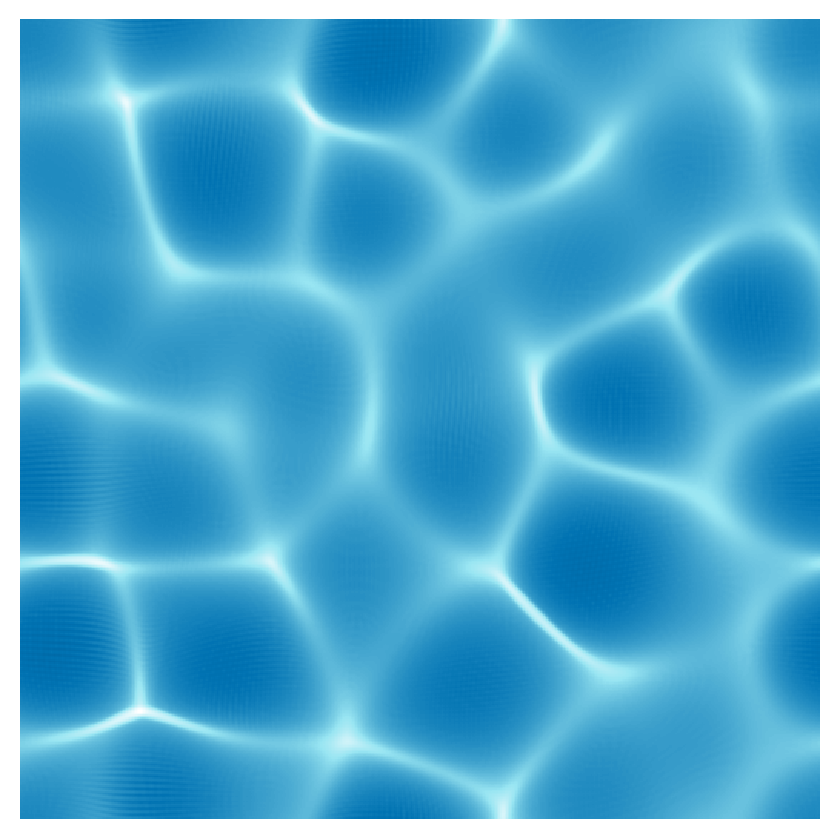

In [8]:
#!/usr/bin/env python3
"""
Pool caustics simulator (geometric optics) — pool-like wavelengths and colors.

This version:
  - Uses lambda0 = 0.45 m (pool-scale waves).
  - Creates TWO animations:
      1) With axes and title (for debugging/inspection).
      2) Clean: no axes, no frame, just the caustic image.
  - Exports the clean animation to pool_caustics_clean.mp4 (requires ffmpeg).

Deps: numpy, matplotlib
Optional: scipy (for gaussian_filter). If missing, periodic FFT blur is used instead.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# Spectral ripple surface (band-limited, pool-like)
# ----------------------------

class SpectralRipples:
    """
    Band-limited ripple field using Tessendorf-style time evolution in Fourier space:

        H(k,t) = h0(k) e^{ i ω t } + h0*(−k) e^{ −i ω t }

    Real for all t. Spectrum is a narrow Gaussian around k0 = 2π/lambda0.
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 target_rms: float = 0.008,
                 lambda0: float = 0.45,
                 k_sigma_frac: float = 0.16,
                 direction_deg: float | None = None,
                 dir_spread_deg: float = 90.0,
                 seed: int = 0):
        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.g = 9.81

        rng = np.random.default_rng(seed)

        # Wavevectors on the FFT grid
        kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=self.dx)
        ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=self.dy)
        KX, KY = np.meshgrid(kx, ky)  # (Ny,Nx)
        k = np.sqrt(KX**2 + KY**2)

        # Dispersion (finite depth): ω^2 = g k tanh(kH)
        omega = np.sqrt(self.g * k * np.tanh(k * depth))
        omega[k == 0.0] = 0.0
        self.omega = omega

        # Dominant wavenumber and spectral width in k-space
        k0 = 2.0 * np.pi / max(lambda0, 1e-6)
        sigma_k = max(k_sigma_frac, 1e-6) * k0

        # Narrow band around k0
        S = np.exp(-0.5 * ((k - k0) / sigma_k) ** 2)

        # High-k suppression
        k_cut = 3.0 * k0
        S *= np.exp(-(k / max(k_cut, 1e-9)) ** 4)

        # Optional directionality (wind / push)
        if direction_deg is not None:
            theta = np.arctan2(KY, KX)
            theta0 = np.deg2rad(direction_deg)
            dtheta = np.angle(np.exp(1j * (theta - theta0)))  # wrapped diff
            sigma_th = np.deg2rad(max(dir_spread_deg, 1e-3))
            D = np.exp(-0.5 * (dtheta / sigma_th) ** 2)
            S *= D

        S[k == 0.0] = 0.0

        # Random complex Gaussian h0(k) with variance proportional to S(k)
        h0 = (rng.standard_normal((Ny, Nx)) + 1j * rng.standard_normal((Ny, Nx))) * np.sqrt(S / 2.0)

        # Build h0*(−k) lookup via index map
        iy_neg = (-np.arange(Ny)) % Ny
        ix_neg = (-np.arange(Nx)) % Nx
        h0_neg = h0[iy_neg[:, None], ix_neg[None, :]]
        h0_star_neg = np.conj(h0_neg)

        # Scale to requested RMS height at t=0
        H_hat_0 = h0 + h0_star_neg
        h_spatial_0 = np.fft.ifft2(H_hat_0).real
        rms = h_spatial_0.std()
        scale = (target_rms / rms) if rms > 0 else 1.0

        self.h0 = h0 * scale
        self.h0_star_neg = h0_star_neg * scale

        # Spatial grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

    def height(self, t: float) -> np.ndarray:
        exp_pos = np.exp(1j * self.omega * t)
        exp_neg = np.conj(exp_pos)
        H_hat = self.h0 * exp_pos + self.h0_star_neg * exp_neg
        return np.fft.ifft2(H_hat).real


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def splat_bilinear(img: np.ndarray,
                   x: np.ndarray, y: np.ndarray, w: np.ndarray,
                   Lx: float, Ly: float,
                   wrap: bool) -> None:
    """
    Deposit weighted samples (x,y,w) into img using bilinear splatting.
    img shape: (H,W) corresponds to (y,x).

    wrap=True implements periodic boundary conditions.
    """
    H, W = img.shape

    # Map physical coords to pixel coords in [0,W) and [0,H)
    u = (x / Lx) * W
    v = (y / Ly) * H

    i0 = np.floor(u).astype(np.int64)
    j0 = np.floor(v).astype(np.int64)
    fu = u - i0
    fv = v - j0

    i1 = i0 + 1
    j1 = j0 + 1

    if wrap:
        i0 %= W; i1 %= W
        j0 %= H; j1 %= H
        ww = w
        fuu = fu
        fvv = fv
    else:
        m = (i0 >= 0) & (i1 < W) & (j0 >= 0) & (j1 < H)
        if not np.any(m):
            return
        i0 = i0[m]; i1 = i1[m]
        j0 = j0[m]; j1 = j1[m]
        fuu = fu[m]; fvv = fv[m]
        ww = w[m]

    w00 = ww * (1.0 - fuu) * (1.0 - fvv)
    w10 = ww * (fuu) * (1.0 - fvv)
    w01 = ww * (1.0 - fuu) * (fvv)
    w11 = ww * (fuu) * (fvv)

    np.add.at(img, (j0, i0), w00)
    np.add.at(img, (j0, i1), w10)
    np.add.at(img, (j1, i0), w01)
    np.add.at(img, (j1, i1), w11)


def caustics_frame(surface: SpectralRipples,
                   t: float,
                   bottom_res: int = 520,
                   sun_elev_deg: float = 62.0,
                   sun_az_deg: float = 25.0,
                   n_air: float = 1.0,
                   n_water: float = 1.333,
                   exposure: float = 70.0,
                   gamma: float = 0.80,
                   wrap: bool = True,
                   blur_sigma_px: float | None = 1.5
                   ) -> np.ndarray:
    """
    Compute a tonemapped caustic image on the pool floor for time t.
    Returns float image in [0,1].
    """
    h = surface.height(t)
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    Hdepth = surface.depth

    # Surface slopes
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Downward-going rays in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -Hdepth
    s = (-Hdepth - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate on bottom with bilinear splatting
    img = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    splat_bilinear(img, bx1, by1, w1, Lx=Lx, Ly=Ly, wrap=wrap)

    # Optional blur: finite sun disk / regularization
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def make_water_cmap() -> LinearSegmentedColormap:
    """
    Create a simple water-like colormap:
      dark blue -> deep aqua -> turquoise -> pale cyan -> white.
    """
    colors = [
        (0.0,  (0.01, 0.05, 0.12)),   # very dark blue
        (0.25, (0.02, 0.20, 0.40)),   # deep blue
        (0.50, (0.00, 0.45, 0.70)),   # turquoise
        (0.75, (0.60, 0.90, 0.95)),   # pale cyan
        (1.0,  (1.00, 1.00, 1.00)),   # white highlights
    ]
    return LinearSegmentedColormap.from_list("pool_water", colors)


def display_animation(fig, ani) -> None:
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(
            float(mpl.rcParams.get("animation.embed_limit", 20)), 120.0
        )
        from IPython.display import HTML, display  # type: ignore
        plt.close(fig)
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()
        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # Geometry / discretization
    Nx = Ny = 256
    Lx = Ly = 2.0
    depth = 1.2

    # Output resolution
    if running_in_notebook():
        bottom_res = 520
        frames = 180
    else:
        bottom_res = 700
        frames = 300

    # Sun / optics
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # Surface: lambda0 = 0.45 m as you chose
    lambda0 = 0.45        # dominant wavelength [m]
    k_sigma_frac = 0.16   # spectral width in k-space
    wave_rms = 0.008      # RMS height [m] ~ 8 mm
    direction_deg = None  # or e.g. 0.0 to bias along +x
    dir_spread_deg = 90.0

    # Caustics tonemap / regularization
    exposure = 70.0
    gamma = 0.80
    blur_sigma_px = 1.5

    # Animation
    fps = 30
    dt = 1.0 / fps

    surface = SpectralRipples(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        target_rms=wave_rms,
        lambda0=lambda0,
        k_sigma_frac=k_sigma_frac,
        direction_deg=direction_deg,
        dir_spread_deg=dir_spread_deg,
        seed=3
    )

    water_cmap = make_water_cmap()

    # ----------------- Animation 1: with axes / title -----------------
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel("x [m]")
    ax1.set_ylabel("y [m]")

    img0 = caustics_frame(
        surface, 0.0,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    im1 = ax1.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap=water_cmap,
        vmin=0.0, vmax=1.0
    )
    ax1.set_title("Pool caustics (with axes)")

    def update1(k: int):
        t = k * dt
        img = caustics_frame(
            surface, t,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im1.set_data(img)
        ax1.set_title(
            f"Pool caustics (with axes) | t = {t:7.3f} s  |  λ0={lambda0:.2f} m"
        )
        return (im1,)

    ani1 = FuncAnimation(fig1, update1, frames=frames, interval=1000/fps, blit=False)

    # ----------------- Animation 2: clean image only -----------------
    fig2, ax2 = plt.subplots(figsize=(4, 4), dpi=200)
    ax2.set_axis_off()
    # remove margins, so only image area
    fig2.subplots_adjust(left=0, right=1, bottom=0, top=1)

    im2 = ax2.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap=water_cmap,
        vmin=0.0, vmax=1.0
    )

    def update2(k: int):
        t = k * dt
        img = caustics_frame(
            surface, t,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im2.set_data(img)
        return (im2,)

    ani2 = FuncAnimation(fig2, update2, frames=frames, interval=1000/fps, blit=False)

    # ---- Export clean animation without axes ----
    # Requires ffmpeg to be installed and on PATH.
    from matplotlib.animation import FFMpegWriter
    writer = FFMpegWriter(fps=fps, bitrate=4000)
    ani2.save("pool_caustics_clean.mp4", writer=writer, dpi=200)

    # For interactive use: show the "with axes" version
    display_animation(fig1, ani1)


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
"""
Pool caustics with PDE-simulated surface waves.

Free-surface model: damped, forced wave equation

    η_tt = c^2 ∇² η - γ η_t + F(x,y,t),

with periodic boundary conditions. A localized sinusoidal forcing
patch pumps in waves with a target wavelength λ0. The current height
field η(x,y,t) is used to compute ray refraction and caustics.

This script:
  - Evolves the PDE in time (finite differences, periodic BC).
  - Renders caustics using geometric optics and Snell's law.
  - Creates a clean animation (no axes/frame) in a pool-like colormap.
  - Optionally exports an MP4 (needs ffmpeg).

Dependencies:
  - numpy
  - matplotlib

Optional:
  - scipy (for gaussian_filter). If absent, a periodic FFT blur is used.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# PDE-based surface waves
# ----------------------------

class PDEWaveSurface:
    """
    Damped, forced wave equation:

        η_tt = c^2 ∇² η - γ η_t + F(x,y,t)

    implemented as first-order system:

        v_t = c^2 ∇² η - γ v + F
        η_t = v

    with periodic boundary conditions on a rectangular domain [0,Lx]×[0,Ly].

    We drive waves by a localized sinusoidal forcing patch F(x,y,t)
    with frequency chosen to target a wavelength λ0:

        ω0 = c * k0,  k0 = 2π/λ0  ⇒  λ ≈ λ0

    This is non-dispersive (shallow-water-like) but has the right
    length scale and is local in physical space.
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 c: float | None = None,
                 gamma: float = 0.8,
                 lambda0: float = 0.45,
                 forcing_amp: float = 0.25,
                 forcing_sigma: float = 0.20,
                 forcing_center: tuple[float, float] | None = None):
        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth

        self.dx = Lx / Nx
        self.dy = Ly / Ny

        # Use c ~ sqrt(g H) as a reasonable shallow-water wave speed
        if c is None:
            g = 9.81
            c = np.sqrt(g * depth)
        self.c = float(c)
        self.gamma = float(gamma)

        # Grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

        # State variables
        self.eta = np.zeros((Ny, Nx), dtype=np.float64)  # surface height
        self.v = np.zeros_like(self.eta)                 # time derivative η_t
        self.t = 0.0

        # Forcing parameters: drive waves near λ0
        self.lambda0 = float(lambda0)
        k0 = 2.0 * np.pi / self.lambda0
        self.omega0 = self.c * k0  # dispersion of wave equation: ω = c k

        self.forcing_amp = float(forcing_amp)
        self.forcing_sigma = float(forcing_sigma)

        if forcing_center is None:
            x0 = 0.3 * Lx
            y0 = 0.5 * Ly
        else:
            x0, y0 = forcing_center

        r2 = (self.X - x0)**2 + (self.Y - y0)**2
        self.forcing_profile = np.exp(-r2 / (2.0 * self.forcing_sigma**2))

    def laplacian(self, f: np.ndarray) -> np.ndarray:
        """
        Periodic Laplacian via 5-point stencil using np.roll.
        """
        return (
            np.roll(f, +1, axis=0) + np.roll(f, -1, axis=0) +
            np.roll(f, +1, axis=1) + np.roll(f, -1, axis=1) -
            4.0 * f
        ) / (self.dx * self.dy)  # crude; strictly we’d use dx², dy² separately,
                                 # but dx=dy here, so dx*dy = dx².

    def step(self, dt: float, nsteps: int = 1) -> None:
        """
        Advance the PDE by nsteps of size dt.
        """
        c2 = self.c * self.c
        gamma = self.gamma
        for _ in range(nsteps):
            # Forcing term in η_tt
            F = self.forcing_amp * np.sin(self.omega0 * self.t) * self.forcing_profile

            lap_eta = self.laplacian(self.eta)
            # v_t = c^2 ∇² η - γ v + F
            dv = c2 * lap_eta - gamma * self.v + F
            self.v += dt * dv
            self.eta += dt * self.v

            self.t += dt


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def splat_bilinear(img: np.ndarray,
                   x: np.ndarray, y: np.ndarray, w: np.ndarray,
                   Lx: float, Ly: float,
                   wrap: bool) -> None:
    """
    Deposit weighted samples (x,y,w) into img using bilinear splatting.
    img shape: (H,W) corresponds to (y,x).

    wrap=True implements periodic boundary conditions.
    """
    H, W = img.shape

    # Map physical coords to pixel coords in [0,W) and [0,H)
    u = (x / Lx) * W
    v = (y / Ly) * H

    i0 = np.floor(u).astype(np.int64)
    j0 = np.floor(v).astype(np.int64)
    fu = u - i0
    fv = v - j0

    i1 = i0 + 1
    j1 = j0 + 1

    if wrap:
        i0 %= W; i1 %= W
        j0 %= H; j1 %= H
        ww = w
        fuu = fu
        fvv = fv
    else:
        m = (i0 >= 0) & (i1 < W) & (j0 >= 0) & (j1 < H)
        if not np.any(m):
            return
        i0 = i0[m]; i1 = i1[m]
        j0 = j0[m]; j1 = j1[m]
        fuu = fu[m]; fvv = fv[m]
        ww = w[m]

    w00 = ww * (1.0 - fuu) * (1.0 - fvv)
    w10 = ww * (fuu) * (1.0 - fvv)
    w01 = ww * (1.0 - fuu) * (fvv)
    w11 = ww * (fuu) * (fvv)

    np.add.at(img, (j0, i0), w00)
    np.add.at(img, (j0, i1), w10)
    np.add.at(img, (j1, i0), w01)
    np.add.at(img, (j1, i1), w11)


def caustics_from_surface(surface: PDEWaveSurface,
                          bottom_res: int = 520,
                          sun_elev_deg: float = 62.0,
                          sun_az_deg: float = 25.0,
                          n_air: float = 1.0,
                          n_water: float = 1.333,
                          exposure: float = 70.0,
                          gamma: float = 0.80,
                          wrap: bool = True,
                          blur_sigma_px: float | None = 1.5
                          ) -> np.ndarray:
    """
    Compute a caustic image on the pool floor from the current state of the PDE surface.
    Returns float image in [0,1].
    """
    h = surface.eta
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    Hdepth = surface.depth

    # Surface slopes
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Downward-going rays in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -Hdepth
    s = (-Hdepth - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate on bottom with bilinear splatting
    img = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    splat_bilinear(img, bx1, by1, w1, Lx=Lx, Ly=Ly, wrap=wrap)

    # Optional blur: finite sun disk / regularization
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def make_water_cmap() -> LinearSegmentedColormap:
    """
    Pool-like colormap:
      dark blue -> deep aqua -> turquoise -> pale cyan -> white.
    """
    colors = [
        (0.0,  (0.01, 0.05, 0.12)),   # very dark blue
        (0.25, (0.02, 0.20, 0.40)),   # deep blue
        (0.50, (0.00, 0.45, 0.70)),   # turquoise
        (0.75, (0.60, 0.90, 0.95)),   # pale cyan
        (1.0,  (1.00, 1.00, 1.00)),   # white highlights
    ]
    return LinearSegmentedColormap.from_list("pool_water", colors)


def display_animation(fig, ani) -> None:
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(
            float(mpl.rcParams.get("animation.embed_limit", 20)), 120.0
        )
        from IPython.display import HTML, display  # type: ignore
        plt.close(fig)
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()
        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # Geometry / discretization
    Nx = Ny = 256
    Lx = Ly = 2.0
    depth = 1.2

    # Animation + PDE stepping parameters
    fps = 30
    dt_frame = 1.0 / fps

    # Choose PDE time step from CFL: dt_pde << dx/c
    # For dx ~ 2/256 ~ 7.8 mm and c ~ sqrt(g H) ~ 3.4 m/s, dt_pde=1e-3 is safe.
    dt_pde = 1.0e-3
    substeps_per_frame = int(round(dt_frame / dt_pde))  # ≈ 33

    # Output resolution
    if running_in_notebook():
        bottom_res = 520
        frames = 180
    else:
        bottom_res = 700
        frames = 300

    # Sun / optics
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # Surface: PDE-based waves with target λ0
    lambda0 = 0.45       # dominant wavelength [m]
    gamma = 0.8          # damping
    forcing_amp = 0.25   # strength of forcing
    forcing_sigma = 0.20 # spatial width of forcing patch [m]

    # Caustics tonemap / regularization
    exposure = 70.0
    gamma_img = 0.80
    blur_sigma_px = 1.5

    surface = PDEWaveSurface(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        c=None,                 # use sqrt(g H)
        gamma=gamma,
        lambda0=lambda0,
        forcing_amp=forcing_amp,
        forcing_sigma=forcing_sigma,
        forcing_center=None
    )

    water_cmap = make_water_cmap()

    # Prepare figure: clean, no axes/frame (nice for video)
    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Spin up PDE a bit so we don't start from flat water
    spinup_steps = 500
    surface.step(dt_pde, nsteps=spinup_steps)

    img0 = caustics_from_surface(
        surface,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma_img,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap=water_cmap,
        vmin=0.0, vmax=1.0
    )

    def update(k: int):
        # Advance the PDE a bit between frames
        surface.step(dt_pde, nsteps=substeps_per_frame)

        img = caustics_from_surface(
            surface,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma_img,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        return (im,)

    ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)

    # Optional: export MP4 (requires ffmpeg on PATH)
    # from matplotlib.animation import FFMpegWriter
    # writer = FFMpegWriter(fps=fps, bitrate=4000)
    # ani.save("pool_caustics_pde_lambda045.mp4", writer=writer, dpi=200)

    display_animation(fig, ani)


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
"""
Pool caustics with PDE-simulated surface waves (fixed amplitude).

Free-surface model: damped, forced wave equation

    η_tt = c^2 ∇² η - γ η_t + F(x,y,t),

with periodic BCs. A localized sinusoidal forcing patch pumps in waves with
target wavelength λ0. The current height field η(x,y,t) is used to compute
ray refraction and caustics.

Changes vs previous PDE version:
  - Forcing amplitude increased massively (to ~150) so η has cm-scale
    variations instead of ~microns.
  - Longer spin-up (wave field develops before first frame).
  - Laplacian cleaned up (uses dx**2; dx=dy).
  - Everything else (optics, caustics, colours, clean video) unchanged.

Dependencies:
  - numpy
  - matplotlib

Optional:
  - scipy (for gaussian_filter). If absent, periodic FFT blur is used.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# PDE-based surface waves
# ----------------------------

class PDEWaveSurface:
    """
    Damped, forced wave equation:

        η_tt = c^2 ∇² η - γ η_t + F(x,y,t)

    as first-order system:

        v_t = c^2 ∇² η - γ v + F
        η_t = v

    Periodic BCs on [0,Lx]×[0,Ly].

    Forcing: localized sinusoidal patch with frequency tuned to λ0:

        ω0 = c k0,  k0 = 2π/λ0  ⇒  dominant λ ≈ λ0

    This is a linear shallow-water-like model: non-dispersive, but cheap and
    good enough to generate realistic wave patterns at the desired scale.
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 c: float | None = None,
                 gamma: float = 0.8,
                 lambda0: float = 0.45,
                 forcing_amp: float = 150.0,
                 forcing_sigma: float = 0.20,
                 forcing_center: tuple[float, float] | None = None):

        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth

        self.dx = Lx / Nx
        self.dy = Ly / Ny

        # Use c ~ sqrt(g H)
        if c is None:
            g = 9.81
            c = np.sqrt(g * depth)
        self.c = float(c)
        self.gamma = float(gamma)

        # Grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

        # State
        self.eta = np.zeros((Ny, Nx), dtype=np.float64)
        self.v = np.zeros_like(self.eta)
        self.t = 0.0

        # Forcing tuned to λ0
        self.lambda0 = float(lambda0)
        k0 = 2.0 * np.pi / self.lambda0
        self.omega0 = self.c * k0

        self.forcing_amp = float(forcing_amp)
        self.forcing_sigma = float(forcing_sigma)

        if forcing_center is None:
            x0 = 0.3 * Lx
            y0 = 0.5 * Ly
        else:
            x0, y0 = forcing_center

        r2 = (self.X - x0) ** 2 + (self.Y - y0) ** 2
        self.forcing_profile = np.exp(-r2 / (2.0 * self.forcing_sigma**2))

    def laplacian(self, f: np.ndarray) -> np.ndarray:
        """
        Periodic Laplacian via 5-point stencil. Here dx=dy, so:

            ∇² f ≈ (f_{i+1,j}+f_{i-1,j}+f_{i,j+1}+f_{i,j-1}-4f_{i,j}) / dx²
        """
        dx2 = self.dx * self.dx
        return (
            np.roll(f, +1, axis=0) + np.roll(f, -1, axis=0) +
            np.roll(f, +1, axis=1) + np.roll(f, -1, axis=1) -
            4.0 * f
        ) / dx2

    def step(self, dt: float, nsteps: int = 1) -> None:
        """
        Advance the PDE by nsteps of size dt.
        """
        c2 = self.c * self.c
        gamma = self.gamma
        for _ in range(nsteps):
            # Forcing
            F = self.forcing_amp * np.sin(self.omega0 * self.t) * self.forcing_profile

            lap_eta = self.laplacian(self.eta)
            dv = c2 * lap_eta - gamma * self.v + F
            self.v += dt * dv
            self.eta += dt * self.v

            self.t += dt


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def splat_bilinear(img: np.ndarray,
                   x: np.ndarray, y: np.ndarray, w: np.ndarray,
                   Lx: float, Ly: float,
                   wrap: bool) -> None:
    """
    Deposit weighted samples (x,y,w) into img using bilinear splatting.
    img shape: (H,W) corresponds to (y,x).

    wrap=True implements periodic boundary conditions.
    """
    H, W = img.shape

    u = (x / Lx) * W
    v = (y / Ly) * H

    i0 = np.floor(u).astype(np.int64)
    j0 = np.floor(v).astype(np.int64)
    fu = u - i0
    fv = v - j0

    i1 = i0 + 1
    j1 = j0 + 1

    if wrap:
        i0 %= W; i1 %= W
        j0 %= H; j1 %= H
        ww = w
        fuu = fu
        fvv = fv
    else:
        m = (i0 >= 0) & (i1 < W) & (j0 >= 0) & (j1 < H)
        if not np.any(m):
            return
        i0 = i0[m]; i1 = i1[m]
        j0 = j0[m]; j1 = j1[m]
        fuu = fu[m]; fvv = fv[m]
        ww = w[m]

    w00 = ww * (1.0 - fuu) * (1.0 - fvv)
    w10 = ww * (fuu) * (1.0 - fvv)
    w01 = ww * (1.0 - fuu) * (fvv)
    w11 = ww * (fuu) * (fvv)

    np.add.at(img, (j0, i0), w00)
    np.add.at(img, (j0, i1), w10)
    np.add.at(img, (j1, i0), w01)
    np.add.at(img, (j1, i1), w11)


def caustics_from_surface(surface: PDEWaveSurface,
                          bottom_res: int = 520,
                          sun_elev_deg: float = 62.0,
                          sun_az_deg: float = 25.0,
                          n_air: float = 1.0,
                          n_water: float = 1.333,
                          exposure: float = 70.0,
                          gamma: float = 0.80,
                          wrap: bool = True,
                          blur_sigma_px: float | None = 1.5
                          ) -> np.ndarray:
    """
    Compute a caustic image on the pool floor from the current PDE surface.
    Returns float image in [0,1].
    """
    h = surface.eta
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    Hdepth = surface.depth

    # Surface slopes
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Downward-going rays in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -Hdepth
    s = (-Hdepth - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate with bilinear splatting
    img = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    splat_bilinear(img, bx1, by1, w1, Lx=Lx, Ly=Ly, wrap=wrap)

    # Optional blur: finite sun disk / regularization
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def make_water_cmap() -> LinearSegmentedColormap:
    """
    Pool-like colormap:
      dark blue -> deep aqua -> turquoise -> pale cyan -> white.
    """
    colors = [
        (0.0,  (0.01, 0.05, 0.12)),   # very dark blue
        (0.25, (0.02, 0.20, 0.40)),   # deep blue
        (0.50, (0.00, 0.45, 0.70)),   # turquoise
        (0.75, (0.60, 0.90, 0.95)),   # pale cyan
        (1.0,  (1.00, 1.00, 1.00)),   # white highlights
    ]
    return LinearSegmentedColormap.from_list("pool_water", colors)


def display_animation(fig, ani) -> None:
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(
            float(mpl.rcParams.get("animation.embed_limit", 20)), 120.0
        )
        from IPython.display import HTML, display  # type: ignore
        plt.close(fig)
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()
        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # Geometry / discretization
    Nx = Ny = 256
    Lx = Ly = 2.0
    depth = 1.2

    # Animation + PDE stepping
    fps = 30
    dt_frame = 1.0 / fps

    # CFL-ish time step
    dt_pde = 1.0e-3
    substeps_per_frame = int(round(dt_frame / dt_pde))  # ~33

    # Output resolution
    if running_in_notebook():
        bottom_res = 520
        frames = 180
    else:
        bottom_res = 700
        frames = 300

    # Sun / optics
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # Surface PDE params
    lambda0 = 0.45        # target wavelength [m]
    gamma = 0.8           # damping
    forcing_amp = 150.0   # BIG: gives ~cm-scale η
    forcing_sigma = 0.20  # forcing patch size [m]

    # Caustics
    exposure = 70.0
    gamma_img = 0.80
    blur_sigma_px = 1.5

    surface = PDEWaveSurface(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        c=None,
        gamma=gamma,
        lambda0=lambda0,
        forcing_amp=forcing_amp,
        forcing_sigma=forcing_sigma,
        forcing_center=None
    )

    water_cmap = make_water_cmap()

    # Clean figure: no axes/frame
    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Spin-up so waves are developed before first frame
    spinup_steps = 5000   # 5000 * 1e-3 = 5 s of PDE time
    surface.step(dt_pde, nsteps=spinup_steps)

    img0 = caustics_from_surface(
        surface,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma_img,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap=water_cmap,
        vmin=0.0, vmax=1.0
    )

    def update(k: int):
        # Advance surface
        surface.step(dt_pde, nsteps=substeps_per_frame)

        img = caustics_from_surface(
            surface,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma_img,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        return (im,)

    ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)

    # Optional export:
    # from matplotlib.animation import FFMpegWriter
    # writer = FFMpegWriter(fps=fps, bitrate=4000)
    # ani.save("pool_caustics_pde_lambda045.mp4", writer=writer, dpi=200)

    display_animation(fig, ani)


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
"""
Pool caustics with PDE-simulated surface waves + stochastic forcing.

Surface model: damped, forced wave equation

    η_tt = c^2 ∇² η - γ η_t + F_drive(x,y,t) + σ_ξ ξ(x,y,t),

with periodic BCs. F_drive is a localized sinusoidal patch tuned to produce
waves with dominant wavelength λ0. ξ is a spatially correlated Gaussian
noise field (via spectral low-pass filtering), which breaks the regular
eigenmode / Chladni patterns and mimics stochastic boundary forcing.

The current height field η(x,y,t) is used to compute ray refraction and
caustics on the pool floor.

Dependencies:
  - numpy
  - matplotlib

Optional:
  - scipy (for gaussian_filter). If absent, a periodic FFT blur is used.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# PDE-based stochastic surface waves
# ----------------------------

class PDEWaveSurface:
    """
    Damped, forced wave equation with stochastic forcing:

        η_tt = c^2 ∇² η - γ η_t + F_drive(x,y,t) + σ_ξ ξ(x,y,t)

    Implemented as first-order system:

        v_t = c^2 ∇² η - γ v + F_drive + σ_ξ ξ
        η_t = v

    Periodic BCs on [0,Lx]×[0,Ly].

    F_drive: localized sinusoidal patch at frequency ω0 tuned to target
             wavelength λ0 via ω0 = c k0, k0 = 2π/λ0.
    ξ: spatially correlated Gaussian noise, obtained by filtering white
       noise in k-space with exp(-0.5 * (ℓ_noise^2 k^2)).
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 c: float | None = None,
                 gamma: float = 0.8,
                 lambda0: float = 0.45,
                 forcing_amp: float = 100.0,
                 forcing_sigma: float = 0.20,
                 forcing_center: tuple[float, float] | None = None,
                 noise_sigma: float = 55.0,
                 noise_ell: float = 0.30,
                 seed: int = 0):

        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth

        self.dx = Lx / Nx
        self.dy = Ly / Ny

        # Wave speed: shallow-water approximation c ~ sqrt(g H)
        if c is None:
            g = 9.81
            c = np.sqrt(g * depth)
        self.c = float(c)
        self.gamma = float(gamma)

        # Grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

        # State
        self.eta = np.zeros((Ny, Nx), dtype=np.float64)
        self.v = np.zeros_like(self.eta)
        self.t = 0.0

        # Forcing tuned to λ0
        self.lambda0 = float(lambda0)
        k0 = 2.0 * np.pi / self.lambda0
        self.omega0 = self.c * k0

        self.forcing_amp = float(forcing_amp)
        self.forcing_sigma = float(forcing_sigma)

        if forcing_center is None:
            x0 = 0.3 * Lx
            y0 = 0.5 * Ly
        else:
            x0, y0 = forcing_center

        r2 = (self.X - x0) ** 2 + (self.Y - y0) ** 2
        self.forcing_profile = np.exp(-r2 / (2.0 * self.forcing_sigma**2))

        # Stochastic forcing parameters
        self.noise_sigma = float(noise_sigma)
        self.rng = np.random.default_rng(seed)

        # Precompute spectral filter for colored noise
        kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=self.dx)
        ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=self.dy)
        KX, KY = np.meshgrid(kx, ky)
        K2 = KX**2 + KY**2

        ell = float(noise_ell)  # correlation length [m]
        self.noise_filter = np.exp(-0.5 * (ell**2) * K2)

    def laplacian(self, f: np.ndarray) -> np.ndarray:
        """
        Periodic Laplacian via 5-point stencil. With dx=dy:

            ∇² f ≈ (f_{i+1,j}+f_{i-1,j}+f_{i,j+1}+f_{i,j-1}-4f_{i,j}) / dx²
        """
        dx2 = self.dx * self.dx
        return (
            np.roll(f, +1, axis=0) + np.roll(f, -1, axis=0) +
            np.roll(f, +1, axis=1) + np.roll(f, -1, axis=1) -
            4.0 * f
        ) / dx2

    def _stochastic_field(self) -> np.ndarray:
        """
        Generate a spatially correlated Gaussian noise field by filtering
        white noise in k-space with the precomputed noise_filter.

        Result has zero mean and O(1) standard deviation before scaling
        by noise_sigma.
        """
        xi = self.rng.standard_normal(self.eta.shape)
        Xi = np.fft.fft2(xi)
        xi_smooth = np.fft.ifft2(Xi * self.noise_filter).real
        # Normalize to unit std to make noise_sigma meaningful
        std = xi_smooth.std()
        if std > 1e-12:
            xi_smooth /= std
        return xi_smooth

    def step(self, dt: float, nsteps: int = 1) -> None:
        """
        Advance the PDE by nsteps of size dt.
        """
        c2 = self.c * self.c
        gamma = self.gamma
        sigma_noise = self.noise_sigma

        for _ in range(nsteps):
            # Harmonic localized driving
            F_drive = self.forcing_amp * np.sin(self.omega0 * self.t) * self.forcing_profile

            # Stochastic forcing (colored noise)
            if sigma_noise > 0.0:
                xi = self._stochastic_field()
            else:
                xi = 0.0

            lap_eta = self.laplacian(self.eta)
            dv = c2 * lap_eta - gamma * self.v + F_drive + sigma_noise * xi
            self.v += dt * dv
            self.eta += dt * self.v

            self.t += dt


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def splat_bilinear(img: np.ndarray,
                   x: np.ndarray, y: np.ndarray, w: np.ndarray,
                   Lx: float, Ly: float,
                   wrap: bool) -> None:
    """
    Deposit weighted samples (x,y,w) into img using bilinear splatting.
    img shape: (H,W) corresponds to (y,x).

    wrap=True implements periodic boundary conditions.
    """
    H, W = img.shape

    u = (x / Lx) * W
    v = (y / Ly) * H

    i0 = np.floor(u).astype(np.int64)
    j0 = np.floor(v).astype(np.int64)
    fu = u - i0
    fv = v - j0

    i1 = i0 + 1
    j1 = j0 + 1

    if wrap:
        i0 %= W; i1 %= W
        j0 %= H; j1 %= H
        ww = w
        fuu = fu
        fvv = fv
    else:
        m = (i0 >= 0) & (i1 < W) & (j0 >= 0) & (j1 < H)
        if not np.any(m):
            return
        i0 = i0[m]; i1 = i1[m]
        j0 = j0[m]; j1 = j1[m]
        fuu = fu[m]; fvv = fv[m]
        ww = w[m]

    w00 = ww * (1.0 - fuu) * (1.0 - fvv)
    w10 = ww * (fuu) * (1.0 - fvv)
    w01 = ww * (1.0 - fuu) * (fvv)
    w11 = ww * (fuu) * (fvv)

    np.add.at(img, (j0, i0), w00)
    np.add.at(img, (j0, i1), w10)
    np.add.at(img, (j1, i0), w01)
    np.add.at(img, (j1, i1), w11)


def caustics_from_surface(surface: PDEWaveSurface,
                          bottom_res: int = 520,
                          sun_elev_deg: float = 62.0,
                          sun_az_deg: float = 25.0,
                          n_air: float = 1.0,
                          n_water: float = 1.333,
                          exposure: float = 70.0,
                          gamma: float = 0.80,
                          wrap: bool = True,
                          blur_sigma_px: float | None = 1.5
                          ) -> np.ndarray:
    """
    Compute a caustic image on the pool floor from the current PDE surface.
    Returns float image in [0,1].
    """
    h = surface.eta
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    Hdepth = surface.depth

    # Surface slopes
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Downward-going rays in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -Hdepth
    s = (-Hdepth - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate with bilinear splatting
    img = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    splat_bilinear(img, bx1, by1, w1, Lx=Lx, Ly=Ly, wrap=wrap)

    # Optional blur: finite sun disk / regularization
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def make_water_cmap() -> LinearSegmentedColormap:
    """
    Pool-like colormap:
      dark blue -> deep aqua -> turquoise -> pale cyan -> white.
    """
    colors = [
        (0.0,  (0.01, 0.05, 0.12)),   # very dark blue
        (0.25, (0.02, 0.20, 0.40)),   # deep blue
        (0.50, (0.00, 0.45, 0.70)),   # turquoise
        (0.75, (0.60, 0.90, 0.95)),   # pale cyan
        (1.0,  (1.00, 1.00, 1.00)),   # white highlights
    ]
    return LinearSegmentedColormap.from_list("pool_water", colors)


def display_animation(fig, ani) -> None:
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(
            float(mpl.rcParams.get("animation.embed_limit", 20)), 120.0
        )
        from IPython.display import HTML, display  # type: ignore
        plt.close(fig)
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()
        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # Geometry / discretization
    Nx = Ny = 256
    Lx = Ly = 2.0
    depth = 1.2

    # Animation + PDE stepping
    fps = 30
    dt_frame = 1.0 / fps

    # CFL-ish time step
    dt_pde = 1.0e-3
    substeps_per_frame = int(round(dt_frame / dt_pde))  # ~33

    # Output resolution
    if running_in_notebook():
        bottom_res = 520
        frames = 180
    else:
        bottom_res = 700
        frames = 300

    # Sun / optics
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # Surface PDE params
    lambda0 = 0.45        # target wavelength [m]
    gamma = 0.8           # damping
    forcing_amp = 80.0    # coherent driving strength
    forcing_sigma = 0.20  # forcing patch size [m]
    noise_sigma = 35.0     # stochastic forcing amplitude
    noise_ell = 0.30      # correlation length [m] for noise

    # Caustics
    exposure = 70.0
    gamma_img = 0.80
    blur_sigma_px = 1.5

    surface = PDEWaveSurface(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        c=None,
        gamma=gamma,
        lambda0=lambda0,
        forcing_amp=forcing_amp,
        forcing_sigma=forcing_sigma,
        forcing_center=None,
        noise_sigma=noise_sigma,
        noise_ell=noise_ell,
        seed=3
    )

    water_cmap = make_water_cmap()

    # Clean figure: no axes/frame
    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Spin-up so waves + noise reach a stationary regime
    spinup_steps = 25000   # 5 s of PDE time at dt_pde=1e-3
    surface.step(dt_pde, nsteps=spinup_steps)

    img0 = caustics_from_surface(
        surface,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma_img,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap=water_cmap,
        vmin=0.0, vmax=1.0
    )

    def update(k: int):
        surface.step(dt_pde, nsteps=substeps_per_frame)

        img = caustics_from_surface(
            surface,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma_img,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        return (im,)

    ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)

    # Optional export:
    # from matplotlib.animation import FFMpegWriter
    # writer = FFMpegWriter(fps=fps, bitrate=4000)
    # ani.save("pool_caustics_pde_stochastic_lambda045.mp4", writer=writer, dpi=200)

    display_animation(fig, ani)


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
"""
Pool caustics with PDE-simulated surface waves + stochastic forcing.

Surface model: damped, forced wave equation

    η_tt = c^2 ∇² η - γ η_t + F_drive(x,y,t) + σ_ξ ξ(x,y,t),

with periodic BCs. F_drive is a localized sinusoidal patch tuned to produce
waves with dominant wavelength λ0. ξ is a spatially correlated Gaussian
noise field (via spectral low-pass filtering), which breaks the regular
eigenmode / Chladni patterns and mimics stochastic boundary forcing.

The current height field η(x,y,t) is used to compute ray refraction and
caustics on the pool floor.

Dependencies:
  - numpy
  - matplotlib

Optional:
  - scipy (for gaussian_filter). If absent, a periodic FFT blur is used.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap


# ----------------------------
# Environment detection
# ----------------------------

def running_in_notebook() -> bool:
    try:
        from IPython import get_ipython  # type: ignore
        ip = get_ipython()
        if ip is None:
            return False
        return ip.__class__.__name__ != "TerminalInteractiveShell"
    except Exception:
        return False


# ----------------------------
# Optics helpers
# ----------------------------

def sun_direction(elev_deg: float, az_deg: float) -> np.ndarray:
    """
    Unit direction vector of sunlight rays traveling *downward* (from sun to surface).
    elev_deg: sun elevation above horizon (90 = zenith).
    az_deg: azimuth in x-y plane (0 along +x, 90 along +y).
    """
    elev = np.deg2rad(elev_deg)
    az = np.deg2rad(az_deg)
    sx = np.cos(elev) * np.cos(az)
    sy = np.cos(elev) * np.sin(az)
    sz = -np.sin(elev)  # downward
    v = np.array([sx, sy, sz], dtype=np.float64)
    return v / np.linalg.norm(v)


def refract_air_to_water(I: np.ndarray,
                         nx: np.ndarray, ny: np.ndarray, nz: np.ndarray,
                         n_air: float = 1.0, n_water: float = 1.333
                         ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vector Snell refraction for many surface normals at once.

    I: 3-vector incident direction (constant), rays pointing downward.
    N: (nx,ny,nz) unit normals (upward).

    Returns (tx,ty,tz,cosi), where cosi = cos(theta_i) = -dot(N,I) clipped to [0,1].
    """
    sx, sy, sz = I
    cosi = -(nx * sx + ny * sy + nz * sz)
    cosi = np.clip(cosi, 0.0, 1.0)

    eta = n_air / n_water
    k = 1.0 - eta * eta * (1.0 - cosi * cosi)
    sqrtk = np.sqrt(np.maximum(k, 0.0))

    c2 = eta * cosi - sqrtk
    tx = eta * sx + c2 * nx
    ty = eta * sy + c2 * ny
    tz = eta * sz + c2 * nz
    return tx, ty, tz, cosi


def fresnel_transmission_schlick(cosi: np.ndarray, n1: float, n2: float) -> np.ndarray:
    """
    Unpolarized Fresnel transmission approximation: T ≈ 1 - R, using Schlick for R.
    """
    r0 = ((n1 - n2) / (n1 + n2)) ** 2
    R = r0 + (1.0 - r0) * (1.0 - cosi) ** 5
    return 1.0 - R


# ----------------------------
# PDE-based stochastic surface waves
# ----------------------------

class PDEWaveSurface:
    """
    Damped, forced wave equation with stochastic forcing:

        η_tt = c^2 ∇² η - γ η_t + F_drive(x,y,t) + σ_ξ ξ(x,y,t)

    Implemented as first-order system:

        v_t = c^2 ∇² η - γ v + F_drive + σ_ξ ξ
        η_t = v

    Periodic BCs on [0,Lx]×[0,Ly].

    F_drive: localized sinusoidal patch at frequency ω0 tuned to target
             wavelength λ0 via ω0 = c k0, k0 = 2π/λ0.
    ξ: spatially correlated Gaussian noise, obtained by filtering white
       noise in k-space with exp(-0.5 * (ℓ_noise^2 k^2)).
    """

    def __init__(self,
                 Nx: int = 256, Ny: int = 256,
                 Lx: float = 2.0, Ly: float = 2.0,
                 depth: float = 1.2,
                 c: float | None = None,
                 gamma: float = 0.8,
                 lambda0: float = 0.45,
                 forcing_amp: float = 100.0,
                 forcing_sigma: float = 0.20,
                 forcing_center: tuple[float, float] | None = None,
                 noise_sigma: float = 55.0,
                 noise_ell: float = 0.30,
                 seed: int = 0):

        self.Nx, self.Ny = Nx, Ny
        self.Lx, self.Ly = Lx, Ly
        self.depth = depth

        self.dx = Lx / Nx
        self.dy = Ly / Ny

        # Wave speed: shallow-water approximation c ~ sqrt(g H)
        if c is None:
            g = 9.81
            c = np.sqrt(g * depth)
        self.c = float(c)
        self.gamma = float(gamma)

        # Grid
        x = np.linspace(0.0, Lx, Nx, endpoint=False)
        y = np.linspace(0.0, Ly, Ny, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y)

        # State
        self.eta = np.zeros((Ny, Nx), dtype=np.float64)
        self.v = np.zeros_like(self.eta)
        self.t = 0.0

        # Forcing tuned to λ0
        self.lambda0 = float(lambda0)
        k0 = 2.0 * np.pi / self.lambda0
        self.omega0 = self.c * k0

        self.forcing_amp = float(forcing_amp)
        self.forcing_sigma = float(forcing_sigma)

        if forcing_center is None:
            x0 = 0.3 * Lx
            y0 = 0.5 * Ly
        else:
            x0, y0 = forcing_center

        r2 = (self.X - x0) ** 2 + (self.Y - y0) ** 2
        self.forcing_profile = np.exp(-r2 / (2.0 * self.forcing_sigma**2))

        # Stochastic forcing parameters
        self.noise_sigma = float(noise_sigma)
        self.rng = np.random.default_rng(seed)

        # Precompute spectral filter for colored noise
        kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=self.dx)
        ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=self.dy)
        KX, KY = np.meshgrid(kx, ky)
        K2 = KX**2 + KY**2

        ell = float(noise_ell)  # correlation length [m]
        self.noise_filter = np.exp(-0.5 * (ell**2) * K2)

    def laplacian(self, f: np.ndarray) -> np.ndarray:
        """
        Periodic Laplacian via 5-point stencil. With dx=dy:

            ∇² f ≈ (f_{i+1,j}+f_{i-1,j}+f_{i,j+1}+f_{i,j-1}-4f_{i,j}) / dx²
        """
        dx2 = self.dx * self.dx
        return (
            np.roll(f, +1, axis=0) + np.roll(f, -1, axis=0) +
            np.roll(f, +1, axis=1) + np.roll(f, -1, axis=1) -
            4.0 * f
        ) / dx2

    def _stochastic_field(self) -> np.ndarray:
        """
        Generate a spatially correlated Gaussian noise field by filtering
        white noise in k-space with the precomputed noise_filter.

        Result has zero mean and O(1) standard deviation before scaling
        by noise_sigma.
        """
        xi = self.rng.standard_normal(self.eta.shape)
        Xi = np.fft.fft2(xi)
        xi_smooth = np.fft.ifft2(Xi * self.noise_filter).real
        # Normalize to unit std to make noise_sigma meaningful
        std = xi_smooth.std()
        if std > 1e-12:
            xi_smooth /= std
        return xi_smooth

    def step(self, dt: float, nsteps: int = 1) -> None:
        """
        Advance the PDE by nsteps of size dt.
        """
        c2 = self.c * self.c
        gamma = self.gamma
        sigma_noise = self.noise_sigma

        for _ in range(nsteps):
            # Harmonic localized driving
            F_drive = self.forcing_amp * np.sin(self.omega0 * self.t) * self.forcing_profile

            # Stochastic forcing (colored noise)
            if sigma_noise > 0.0:
                xi = self._stochastic_field()
            else:
                xi = 0.0

            lap_eta = self.laplacian(self.eta)
            dv = c2 * lap_eta - gamma * self.v + F_drive + sigma_noise * xi
            self.v += dt * dv
            self.eta += dt * self.v

            self.t += dt


# ----------------------------
# Rendering utilities
# ----------------------------

def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def splat_bilinear(img: np.ndarray,
                   x: np.ndarray, y: np.ndarray, w: np.ndarray,
                   Lx: float, Ly: float,
                   wrap: bool) -> None:
    """
    Deposit weighted samples (x,y,w) into img using bilinear splatting.
    img shape: (H,W) corresponds to (y,x).

    wrap=True implements periodic boundary conditions.
    """
    H, W = img.shape

    u = (x / Lx) * W
    v = (y / Ly) * H

    i0 = np.floor(u).astype(np.int64)
    j0 = np.floor(v).astype(np.int64)
    fu = u - i0
    fv = v - j0

    i1 = i0 + 1
    j1 = j0 + 1

    if wrap:
        i0 %= W; i1 %= W
        j0 %= H; j1 %= H
        ww = w
        fuu = fu
        fvv = fv
    else:
        m = (i0 >= 0) & (i1 < W) & (j0 >= 0) & (j1 < H)
        if not np.any(m):
            return
        i0 = i0[m]; i1 = i1[m]
        j0 = j0[m]; j1 = j1[m]
        fuu = fu[m]; fvv = fv[m]
        ww = w[m]

    w00 = ww * (1.0 - fuu) * (1.0 - fvv)
    w10 = ww * (fuu) * (1.0 - fvv)
    w01 = ww * (1.0 - fuu) * (fvv)
    w11 = ww * (fuu) * (fvv)

    np.add.at(img, (j0, i0), w00)
    np.add.at(img, (j0, i1), w10)
    np.add.at(img, (j1, i0), w01)
    np.add.at(img, (j1, i1), w11)


def caustics_from_surface(surface: PDEWaveSurface,
                          bottom_res: int = 520,
                          sun_elev_deg: float = 62.0,
                          sun_az_deg: float = 25.0,
                          n_air: float = 1.0,
                          n_water: float = 1.333,
                          exposure: float = 70.0,
                          gamma: float = 0.80,
                          wrap: bool = True,
                          blur_sigma_px: float | None = 1.5
                          ) -> np.ndarray:
    """
    Compute a caustic image on the pool floor from the current PDE surface.
    Returns float image in [0,1].
    """
    h = surface.eta
    X, Y = surface.X, surface.Y
    dx, dy = surface.dx, surface.dy
    Lx, Ly = surface.Lx, surface.Ly
    Hdepth = surface.depth

    # Surface slopes
    hy, hx = np.gradient(h, dy, dx, edge_order=2)

    # Unit normal (upward)
    denom = np.sqrt(1.0 + hx*hx + hy*hy)
    nx = -hx / denom
    ny = -hy / denom
    nz =  1.0 / denom

    I = sun_direction(sun_elev_deg, sun_az_deg)

    # Refract
    tx, ty, tz, cosi = refract_air_to_water(I, nx, ny, nz, n_air=n_air, n_water=n_water)

    # Downward-going rays in water
    mask = tz < -1e-8
    if not np.any(mask):
        return np.zeros((bottom_res, bottom_res), dtype=np.float64)

    # Intersect bottom plane z = -Hdepth
    s = (-Hdepth - h) / tz
    bx = X + s * tx
    by = Y + s * ty

    if wrap:
        bx = np.mod(bx, Lx)
        by = np.mod(by, Ly)

    # Ray power weights: Fresnel transmission + projected flux
    T = fresnel_transmission_schlick(cosi, n_air, n_water)
    w = T * cosi / np.maximum(nz, 1e-8)

    bx1 = bx[mask].ravel()
    by1 = by[mask].ravel()
    w1  = w[mask].ravel()

    # Accumulate with bilinear splatting
    img = np.zeros((bottom_res, bottom_res), dtype=np.float64)
    splat_bilinear(img, bx1, by1, w1, Lx=Lx, Ly=Ly, wrap=wrap)

    # Optional blur: finite sun disk / regularization
    if blur_sigma_px is not None and blur_sigma_px > 0:
        try:
            from scipy.ndimage import gaussian_filter  # type: ignore
            img = gaussian_filter(img, blur_sigma_px, mode="wrap" if wrap else "nearest")
        except Exception:
            img = gaussian_blur_fft(img, blur_sigma_px)

    # Tonemap to [0,1]
    img = img / (img.mean() + 1e-12)
    img = np.log1p(exposure * img)
    img = img / (img.max() + 1e-12)
    img = img ** gamma
    return img


def gaussian_blur_fft(img: np.ndarray, sigma_px: float) -> np.ndarray:
    """Periodic Gaussian blur via FFT (fallback when SciPy is unavailable)."""
    H, W = img.shape
    ky = np.fft.fftfreq(H) * 2.0 * np.pi
    kx = np.fft.fftfreq(W) * 2.0 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    G = np.exp(-0.5 * (sigma_px**2) * (KX*KX + KY*KY))
    return np.fft.ifft2(np.fft.fft2(img) * G).real


def make_water_cmap() -> LinearSegmentedColormap:
    """
    Pool-like colormap:
      dark blue -> deep aqua -> turquoise -> pale cyan -> white.
    """
    colors = [
        (0.0,  (0.01, 0.05, 0.12)),   # very dark blue
        (0.25, (0.02, 0.20, 0.40)),   # deep blue
        (0.50, (0.00, 0.45, 0.70)),   # turquoise
        (0.75, (0.60, 0.90, 0.95)),   # pale cyan
        (1.0,  (1.00, 1.00, 1.00)),   # white highlights
    ]
    return LinearSegmentedColormap.from_list("pool_water", colors)


def display_animation(fig, ani) -> None:
    if running_in_notebook():
        import matplotlib as mpl
        mpl.rcParams["animation.embed_limit"] = max(
            float(mpl.rcParams.get("animation.embed_limit", 20)), 120.0
        )
        from IPython.display import HTML, display  # type: ignore
        plt.close(fig)
        try:
            html = ani.to_html5_video()
        except Exception:
            html = ani.to_jshtml()
        display(HTML(html))
    else:
        plt.show()


# ----------------------------
# Demo / animation
# ----------------------------

def main():
    # Geometry / discretization
    Nx = Ny = 256
    Lx = Ly = 2.0
    depth = 1.2

    # Animation + PDE stepping
    fps = 30
    dt_frame = 1.0 / fps

    # CFL-ish time step
    dt_pde = 1.0e-3
    substeps_per_frame = int(round(dt_frame / dt_pde))  # ~33

    # Base output resolution + base number of frames
    if running_in_notebook():
        bottom_res = 520
        base_frames = 180
    else:
        bottom_res = 700
        base_frames = 300

    # --- Integrate 5× longer, discard first 20% of that as transient ---
    time_factor = 5.0
    total_frames = int(base_frames * time_factor)
    transient_fraction = 0.20
    transient_frames = int(transient_fraction * total_frames)
    visible_frames = total_frames - transient_frames

    # Sun / optics
    sun_elev_deg = 62.0
    sun_az_deg = 25.0
    n_air = 1.0
    n_water = 1.333

    # Surface PDE params
    # Original lambda0 was 0.45 m → now 4× shorter:
    lambda0 = 0.45 / 4.0   # ≈ 0.1125 m
    gamma = 0.8            # damping
    forcing_amp = 80.0     # coherent driving strength
    forcing_sigma = 0.20   # forcing patch size [m]
    noise_sigma = 35.0     # stochastic forcing amplitude
    noise_ell = 0.30       # correlation length [m] for noise

    # Caustics
    exposure = 70.0
    gamma_img = 0.80
    blur_sigma_px = 1.5

    surface = PDEWaveSurface(
        Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, depth=depth,
        c=None,
        gamma=gamma,
        lambda0=lambda0,
        forcing_amp=forcing_amp,
        forcing_sigma=forcing_sigma,
        forcing_center=None,
        noise_sigma=noise_sigma,
        noise_ell=noise_ell,
        seed=3
    )

    water_cmap = make_water_cmap()

    # Clean figure: no axes/frame
    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Spin-up so waves + noise reach a stationary regime
    spinup_steps = 25000   # 5 s of PDE time at dt_pde=1e-3
    surface.step(dt_pde, nsteps=spinup_steps)

    # Additional transient integration (discard first 20% of long run)
    transient_steps = transient_frames * substeps_per_frame
    surface.step(dt_pde, nsteps=transient_steps)

    # Initial caustic frame after transient
    img0 = caustics_from_surface(
        surface,
        bottom_res=bottom_res,
        sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
        n_air=n_air, n_water=n_water,
        exposure=exposure, gamma=gamma_img,
        wrap=True,
        blur_sigma_px=blur_sigma_px
    )

    im = ax.imshow(
        img0,
        origin="lower",
        extent=(0.0, Lx, 0.0, Ly),
        interpolation="nearest",
        cmap=water_cmap,
        vmin=0.0, vmax=1.0
    )

    def update(k: int):
        # Regular visible evolution
        surface.step(dt_pde, nsteps=substeps_per_frame)

        img = caustics_from_surface(
            surface,
            bottom_res=bottom_res,
            sun_elev_deg=sun_elev_deg, sun_az_deg=sun_az_deg,
            n_air=n_air, n_water=n_water,
            exposure=exposure, gamma=gamma_img,
            wrap=True,
            blur_sigma_px=blur_sigma_px
        )
        im.set_data(img)
        return (im,)

    ani = FuncAnimation(
        fig,
        update,
        frames=visible_frames,
        interval=1000 / fps,
        blit=False
    )

    # Optional export:
    # from matplotlib.animation import FFMpegWriter
    # writer = FFMpegWriter(fps=fps, bitrate=4000)
    # ani.save(
    #     "pool_caustics_pde_stochastic_lambda01125_longrun.mp4",
    #     writer=writer,
    #     dpi=200
    # )

    display_animation(fig, ani)


if __name__ == "__main__":
    main()
